<a href="https://colab.research.google.com/github/stbalaji/AIForBusiness/blob/main/03%20Speech%20AI/AICH_AIB_L01_TextToSpeech_V01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Module 3D Deep Learning
Speech AI
Exercise 01 Text to Speech

In [1]:
pip install gTTS

In [3]:
from gtts import gTTS
import os

In [4]:
sampleText = "Welcome to Wonderful world of Artifical Intelligence ! Enjoy the Learning"
language = 'en'

audioobj = gTTS(text=sampleText, lang=language, slow=False)
audioobj.save("SpeechToText_SampleAudio.mp3")

In [6]:
# Save the File
os.system("SpeechToText_SampleAudio.mp3")

32512

# Try a Different Accent

# https://gtts.readthedocs.io/en/latest/module.html#languages-gtts-lang

In [7]:
language = 'fr'
audioobj = gTTS(text=sampleText, lang=language, slow=False)
audioobj.save("SpeechToText_SampleAudio_fr.mp3")
os.system("SpeechToText_SampleAudio_fr.mp3")

32512

In [8]:
import os
import tensorflow as tf
import numpy as np
import seaborn as sns
import pathlib
from IPython import display
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

In [ ]:

# Downloading the mini_speech_commands dataset from the external URL
data = tf.keras.utils.get_file(
  'mini_speech_commands.zip',
  origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
  extract=True,
  cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 2s 0us/step


In [ ]:
os.listdir('./data/')

['mini_speech_commands', '__MACOSX', 'mini_speech_commands.zip']

In [ ]:

# Using audio_dataset_from_directory function to create dataset with audio data
training_set, validation_set = tf.keras.utils.audio_dataset_from_directory(
    directory='./data/mini_speech_commands',
    batch_size=16,
    validation_split=0.2,
    output_sequence_length=16000,
    seed=0,
    subset='both')

# Extracting audio labels
label_names = np.array(training_set.class_names)
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.
label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


Drop the extra axis in the audio channel data
Now, we will applying tf.squeeze function to drop the extra axis in the audio channel data.

In [ ]:

# Defining the squeeze function
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

# Applying the function on the dataset obtained from previous step
training_set = training_set.map(squeeze, tf.data.AUTOTUNE)
validation_set = validation_set.map(squeeze, tf.data.AUTOTUNE)

In [ ]:

# Visualize the waveform
audio, label = next(iter(training_set))
display.display(display.Audio(audio[0], rate=16000))

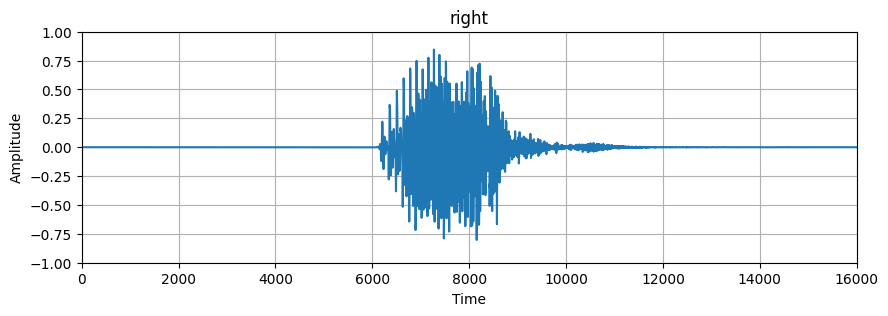

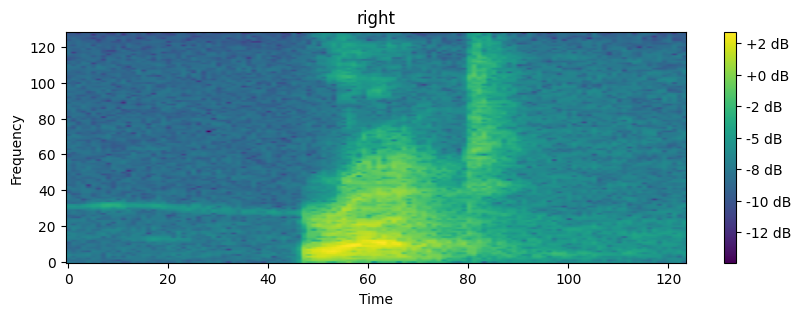

In [ ]:
# Plot the waveform
def plot_wave(waveform, label):
    plt.figure(figsize=(10, 3))
    plt.title(label)
    plt.plot(waveform)
    plt.xlim([0, 16000])
    plt.ylim([-1, 1])
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.grid(True)

# Convert waveform to spectrogram
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram[..., tf.newaxis]

# Plot the spectrogram
def plot_spectrogram(spectrogram, label):
    spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    plt.figure(figsize=(10, 3))
    plt.title(label)
    plt.imshow(log_spec, aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

# Plotting the waveform and the spectrogram of a random sample
audio, label = next(iter(training_set))

# Plot the wave with its label name
plot_wave(audio[0], label_names[label[0]])

# Plot the spectrogram with its label name
plot_spectrogram(get_spectrogram(audio[0]), label_names[label[0]])

In [ ]:

# Creating spectrogram dataset from waveform or audio data
def get_spectrogram_dataset(dataset):
    dataset = dataset.map(
        lambda x, y: (get_spectrogram(x), y),
        num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

# Applying the function on the audio dataset
train_set = get_spectrogram_dataset(training_set)
validation_set = get_spectrogram_dataset(validation_set)

# Dividing validation set into two equal val and test set
val_set = validation_set.take(validation_set.cardinality() // 2)
test_set = validation_set.skip(validation_set.cardinality() // 2)

In [ ]:

train_set_shape = train_set.element_spec[0].shape
val_set_shape = val_set.element_spec[0].shape
test_set_shape = test_set.element_spec[0].shape

print("Train set shape:", train_set_shape)
print("Validation set shape:", val_set_shape)
print("Testing set shape:", test_set_shape)

Train set shape: (None, 124, 129, 1)
Validation set shape: (None, 124, 129, 1)
Testing set shape: (None, 124, 129, 1)


In [ ]:
# Defining the model
def get_model(input_shape, num_labels):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        # Resizing the input to a square image of size 64 x 64 and normalizing it
        tf.keras.layers.Resizing(64, 64),
        tf.keras.layers.Normalization(),

        # Convolution layers followed by MaxPooling layer
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.Conv2D(128, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),

        # Dense layer
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        # Softmax layer to get the label prediction
        tf.keras.layers.Dense(num_labels, activation='softmax')
    ])
    # Printing model summary
    model.summary()
    return model

# Getting input shape from the sample audio and number of classes
input_shape = next(iter(train_set))[0][0].shape
print("Input shape:", input_shape)
num_labels = len(label_names)

# Creating a model
model = get_model(input_shape, num_labels)

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 1)         0         
                                                                 
 normalization (Normalizati  (None, 64, 64, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

EPOCHS = 10
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=EPOCHS,
)

Epoch 1/10
359/400 [=========================>....] - ETA: 29s - loss: 1.4208 - accuracy: 0.5115

In [ ]:

# Plotting the history
metrics = history.history
plt.figure(figsize=(10, 5))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:

# Confusion matrix
y_pred = np.argmax(model.predict(test_set), axis=1)
y_true = np.concatenate([y for x, y in test_set], axis=0)
cm = tf.math.confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:

report = classification_report(y_true, y_pred)
print(report)

In [ ]:

path = 'data/mini_speech_commands/yes/004ae714_nohash_0.wav'
Input = tf.io.read_file(str(path))
x, sample_rate = tf.audio.decode_wav(Input, desired_channels=1, desired_samples=16000,)
audio, labels = squeeze(x, 'yes')

waveform = audio
display.display(display.Audio(waveform, rate=16000))

x = get_spectrogram(audio)
x = tf.expand_dims(x, axis=0)

prediction = model(x)
plt.bar(label_names, tf.nn.softmax(prediction[0]))
plt.title('Prediction : '+label_names[np.argmax(prediction, axis=1).item()])
plt.show()